In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sys, pathlib

# Project-1 folder (parent of this Notebooks/ folder)
proj_dir = pathlib.Path.cwd().parent
if str(proj_dir) not in sys.path:
    sys.path.insert(0, str(proj_dir))

# Figures folder
fig_dir = proj_dir / "Figures"
fig_dir.mkdir(parents=True, exist_ok=True)

from Code.data import make_data, build_features, split_and_scale

# --- Project-wide experiment config (new variables added on as they are introduced) ---

# Data settings
N_SAMPLES   = 300     # number of samples
NOISE_SD    = 0.3     # noise standard deviation
SEED_DATA   = 42      # data generation
SEED_SPLIT  = 42      # train/test split (split_and_scale uses this)
DEG_MAX     = 15      # max polynomial degree for features
P_FIXED     = 15      # fixed polynomial degree for regularization experiments
TEST_SIZE   = 0.20    # train/test split size


# Regularization grids
LAM_GRID_RIDGE = np.logspace(-6, 1, 40)  # wider range for ridge
LAM_GRID_LASSO = np.logspace(-6, 0, 60)  # less range for LASSO

# Optimizer settings
LAM_RIDGE  = 0.0203   # since n_factor=True, this gives α=0.03.. (see alpha_from_lambda)
BETA = 0.3    # momentum parameter
B1 = 0.9    # Adam parameter
B2 = 0.999  # Adam parameter
EPS = 1e-8  # Adam parameter
RHO = 0.99  # Adadelta parameter

# Mini-batch SGD
EPOCHS_MB    = 25     # passes over data
BATCH_SIZE   = 64     # minibatch size
ETA_MB_OLS   = 1e-2   # for OLS, can be larger
ETA_MB_RIDGE = 1e-2   # for ridge, need to tune
SEED_MB      = 42     # minibatch shuffle

B = 500 # number of bootstrap resamples 

# --- Generate data explicitly---
x, y = make_data(n=N_SAMPLES, noise_sd=NOISE_SD, seed=SEED_DATA)
X_full = build_features(x, degree=DEG_MAX, include_bias=False)


X_tr_s, X_te_s, y_tr_c, y_te, scaler, y_mean = split_and_scale(X_full, y, test_size=TEST_SIZE, random_state=SEED_SPLIT)

Xtr_p = X_tr_s[:, :P_FIXED]
Xte_p = X_te_s[:, :P_FIXED]
p = Xtr_p.shape[1]
theta0 = np.zeros(p)

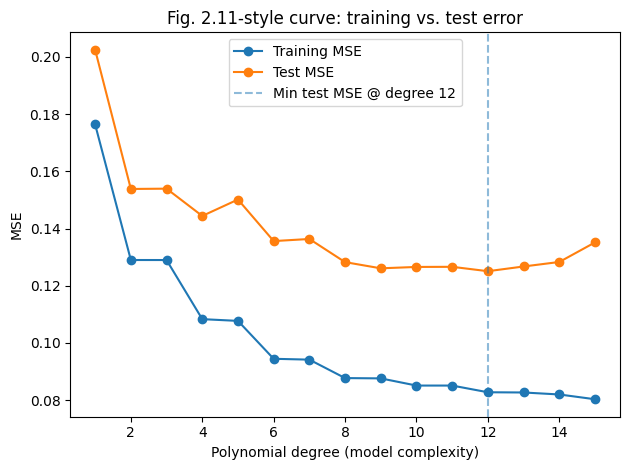

In [ ]:
from Code.models import fit_ols 
from Code.metrics import mse
from Code.models import predict_centered, fit_ols
from Code.resampling import bias_variance_from_preds, bootstrap_predictions

# ===== Fig 2.11-style: train & test MSE vs. model complexity =====
rng = np.random.default_rng(SEED_DATA) 

# one fixed split, centered y 
split = lambda X,Y: split_and_scale(X, Y, test_size=TEST_SIZE, random_state=SEED_SPLIT, center_y=True)
X_tr_s, X_te_s, y_tr_c, y_te, _, y_mean = split(X_full, y)

train_mse, test_mse = [], []
degrees = list(range(1, DEG_MAX + 1))

# loop over polynomial degrees
for p in degrees:
    Xtr_p = X_tr_s[:, :p]
    Xte_p = X_te_s[:, :p]

    theta   = fit_ols(Xtr_p, y_tr_c)                     # fit on centered y
    yhat_tr = predict_centered(Xtr_p, theta, y_mean)   # (n,)
    yhat_te = predict_centered(Xte_p, theta, y_mean)   # (n,)

    # ensure targets are 1-D to match predictions
    y_tr_uncentered = (y_tr_c + y_mean).ravel()
    y_te_1d         = y_te.ravel()

    train_mse.append(mse(y_tr_uncentered, yhat_tr))
    test_mse.append(mse(y_te_1d,        yhat_te))

plt.figure()
plt.plot(degrees, train_mse, marker="o", label="Training MSE")
plt.plot(degrees, test_mse,  marker="o", label="Test MSE")
best_idx = int(np.argmin(test_mse))
plt.axvline(degrees[best_idx], linestyle="--", alpha=0.5,
            label=f"Min test MSE @ degree {degrees[best_idx]}")
plt.xlabel("Polynomial degree (model complexity)")
plt.ylabel("MSE")
plt.title("Fig. 2.11-style curve: training vs. test error")
plt.legend()
plt.savefig(fig_dir / "fig2.11_style.png", dpi=150)
plt.tight_layout()


p= 1: MSE=0.20296  Bias^2=0.20252  Var=0.00045  sum=0.20296
p= 2: MSE=0.15481  Bias^2=0.15382  Var=0.00099  sum=0.15481
p= 3: MSE=0.15536  Bias^2=0.15395  Var=0.00141  sum=0.15536
p= 4: MSE=0.14611  Bias^2=0.14446  Var=0.00165  sum=0.14611
p= 5: MSE=0.15247  Bias^2=0.15040  Var=0.00206  sum=0.15247
p= 6: MSE=0.13783  Bias^2=0.13555  Var=0.00227  sum=0.13783
p= 7: MSE=0.13939  Bias^2=0.13654  Var=0.00285  sum=0.13939
p= 8: MSE=0.13182  Bias^2=0.12894  Var=0.00287  sum=0.13182
p= 9: MSE=0.13104  Bias^2=0.12773  Var=0.00330  sum=0.13104
p=10: MSE=0.13165  Bias^2=0.12797  Var=0.00369  sum=0.13165
p=11: MSE=0.13222  Bias^2=0.12807  Var=0.00415  sum=0.13222
p=12: MSE=0.13279  Bias^2=0.12843  Var=0.00436  sum=0.13279
p=13: MSE=0.13433  Bias^2=0.12948  Var=0.00485  sum=0.13433
p=14: MSE=0.13685  Bias^2=0.13159  Var=0.00525  sum=0.13685
p=15: MSE=0.14140  Bias^2=0.13625  Var=0.00515  sum=0.14140


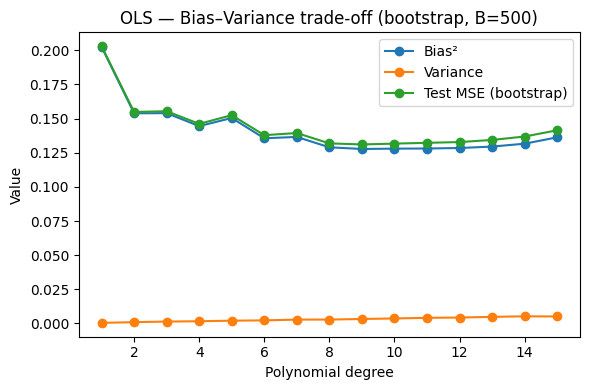

In [ ]:
# ===== 2) Bootstrap bias–variance decomposition on test set =====

bias2_list, var_list, mse_te_list = [], [], [] 

# loop over polynomial degrees
for p in range(1, DEG_MAX + 1):
    Xtr_p = X_tr_s[:, :p]
    Xte_p = X_te_s[:, :p]

    # P has shape (B, n_test): each row = predictions on the SAME held-out test set
    P = bootstrap_predictions(
        fit_fn=fit_ols,             # closed-form OLS on centered y
        pred_fn=predict_centered,   # adds back y_mean for predictions
        Xtr_s=Xtr_p,
        ytr_c=y_tr_c,
        Xte_s=Xte_p,
        y_mean=y_mean,
        B=B,
        seed=SEED_DATA
    )

    # Returns scalars averaged over test points
    bias2, var, mse_boot = bias_variance_from_preds(P, y_true=y_te.ravel())
    bias2_list.append(bias2)
    var_list.append(var)
    mse_te_list.append(mse_boot)

    # per-degree printed in console
    print(f"p={p:2d}: MSE={mse_boot:.5f}  Bias^2={bias2:.5f}  Var={var:.5f}  sum={bias2+var:.5f}")

plt.figure(figsize=(6,4))
plt.plot(range(1, DEG_MAX+1), bias2_list, marker="o", label="Bias²")
plt.plot(range(1, DEG_MAX+1), var_list,   marker="o", label="Variance")
plt.plot(range(1, DEG_MAX+1), mse_te_list,marker="o", label="Test MSE (bootstrap)")
plt.xlabel("Polynomial degree")
plt.ylabel("Value")
plt.title(f"OLS — Bias–Variance trade-off (bootstrap, B={B})")
plt.legend(); plt.tight_layout()
plt.savefig(fig_dir / "g_ols_bias_variance_bootstrap.png", dpi=300, bbox_inches="tight")